### Source: https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/

In [1]:
# Regular
import pandas as pd
import numpy as np
import itertools
import warnings
from pandas import datetime
from datetime import date

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# Statsmosels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
#import pmdarima as pm
from math import sqrt
from pylab import rcParams

plt.style.use('ggplot')

C:\Users\Kristina.popova\AppData\Local\Temp\ipykernel_4060\1900528925.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
all_yrs = pd.read_csv("prepaid_revenues_dataset.csv")
all_yrs['period'] = pd.to_datetime(all_yrs['period'])
all_yrs = all_yrs[['period', 'total_rev']]

#all_yrs = all_yrs.set_index('period')
#data = all_yrs['total_rev'].values.tolist()
all_yrs.tail()

,period,total_rev
94,2023-11-30,29458500
95,2023-12-31,36285000
96,2024-01-31,31598700
97,2024-02-29,26937000
98,2024-03-31,31119000


#### Line Plot

<Figure size 1200x500 with 0 Axes>

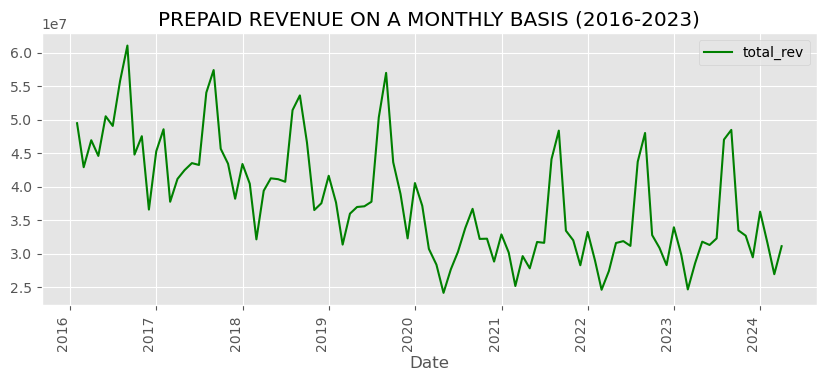

In [3]:
plt.figure(figsize=[12,5])
all_yrs.plot(x='period', y='total_rev', figsize=(10,4), legend=True, color='g')
plt.title("PREPAID REVENUE ON A MONTHLY BASIS (2016-2023)")
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.grid(True)
plt.show()

### Decomposition of the time series

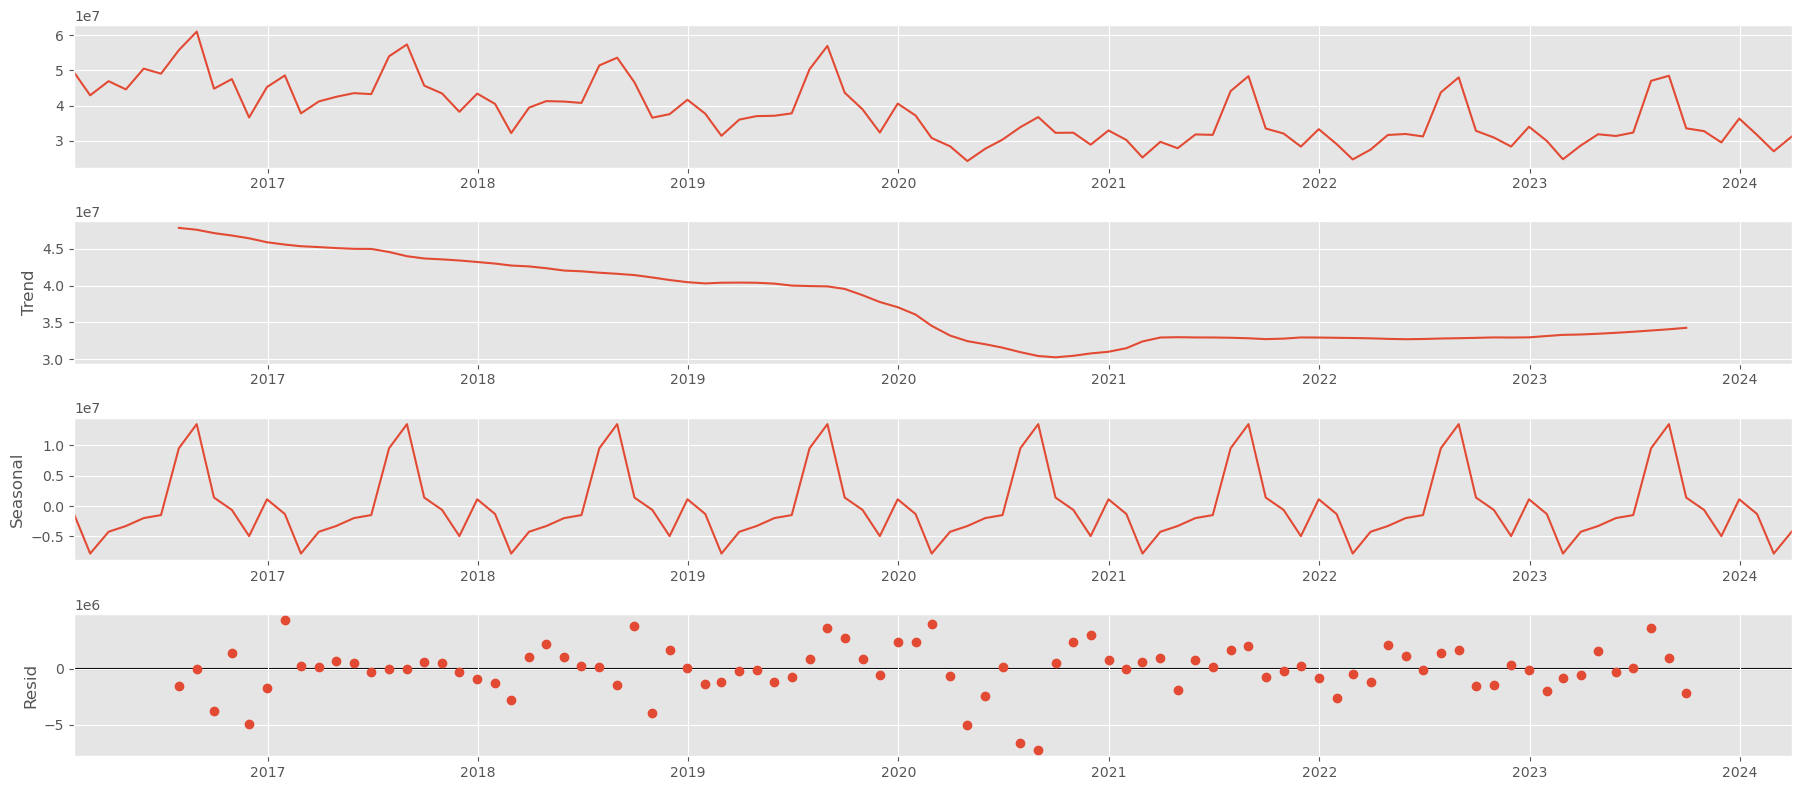

In [4]:
all_yrs = all_yrs.set_index('period')
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(all_yrs, model='additive', period=12)
fig = decomposition.plot()
plt.show()

#### Stats tests

Automated Dickey Fuller test to check if the series is stationary. If it is not then we need to make it stationary. A stationay time series does not have any season or trend.

If p>significance level: We have no evidence that data is stationary, proceed with differencing.
If p<=significance level: We have evidence that the data is stationary, stop with transformations.

In [5]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

print(adf_test(all_yrs))

Results of Dickey-Fuller Test:
Test Statistic                 -1.875993
p-value                         0.343438
#Lags Used                     12.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64
None


#### First-order differencing

Results of Dickey-Fuller Test:
Test Statistic                 -3.550547
p-value                         0.006780
#Lags Used                     11.000000
Number of Observations Used    86.000000
Critical Value (1%)            -3.508783
Critical Value (5%)            -2.895784
Critical Value (10%)           -2.585038
dtype: float64
None


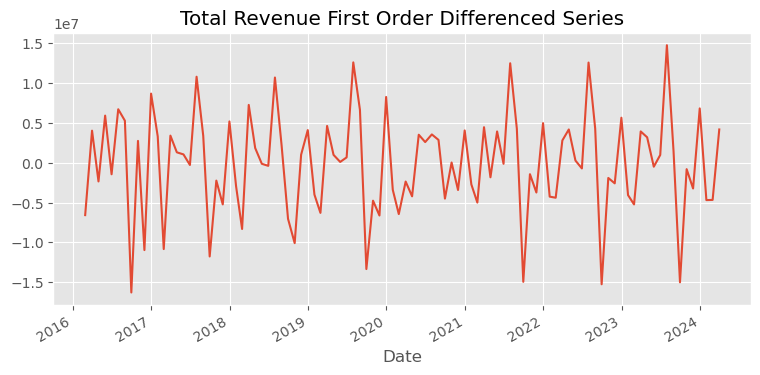

In [6]:
all_yrs['Total Rev. First Difference'] = all_yrs['total_rev'] - all_yrs['total_rev'].shift(1)
all_yrs.dropna(subset='Total Rev. First Difference', inplace=True)

plt.figure(figsize=[9,4])
all_yrs['Total Rev. First Difference'].plot()
plt.title("Total Revenue First Order Differenced Series")
plt.xlabel("Date")

print(adf_test(all_yrs['Total Rev. First Difference']))

#### Seasonal differencing

Text(0.5, 0, 'Date')

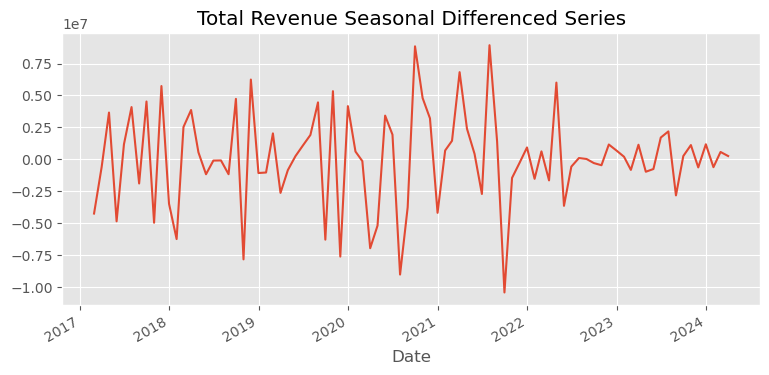

In [7]:
all_yrs['Total Rev. Seasonal Difference'] = all_yrs['Total Rev. First Difference'] - all_yrs['Total Rev. First Difference'].shift(12)

plt.figure(figsize=[9,4])
all_yrs['Total Rev. Seasonal Difference'].plot()
plt.title("Total Revenue Seasonal Differenced Series")
plt.xlabel("Date")

#### Autocorrelation Plots

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

- Autocorrelation before differencing

<Figure size 700x200 with 0 Axes>

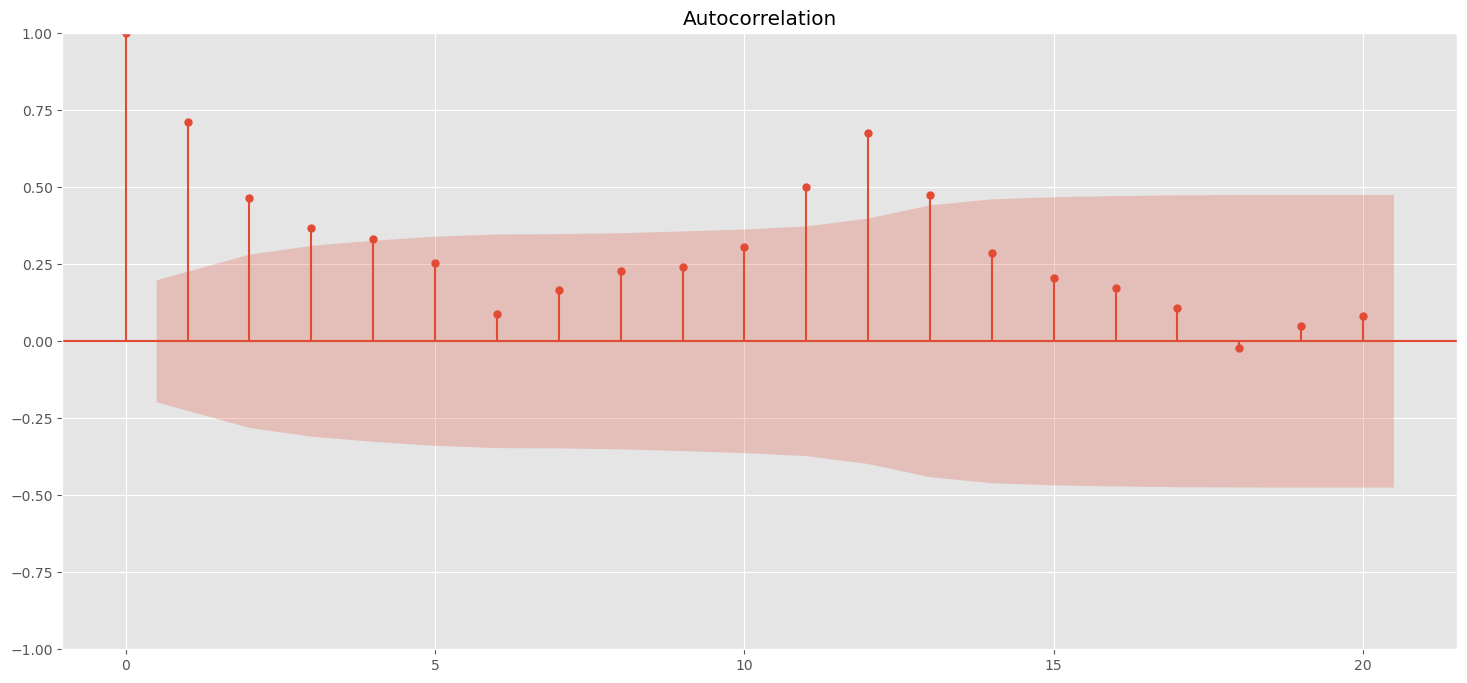

In [8]:
plt.figure(figsize=[7,2])
plot_acf(all_yrs['total_rev'])
plt.show()

- Autocorrelation after first order differencing

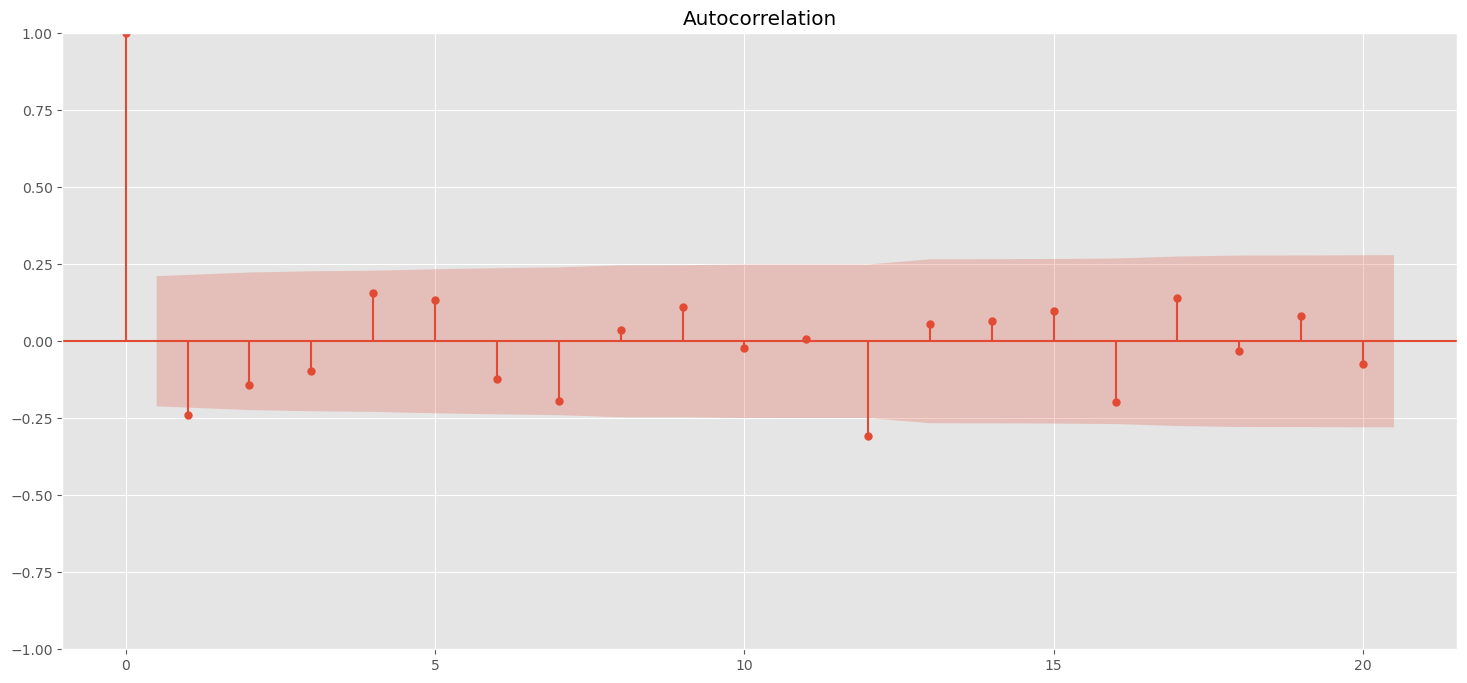

In [9]:
plot_acf(all_yrs['Total Rev. Seasonal Difference'].dropna())
plt.show()

- Partial autocorrelation after first order differencing

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


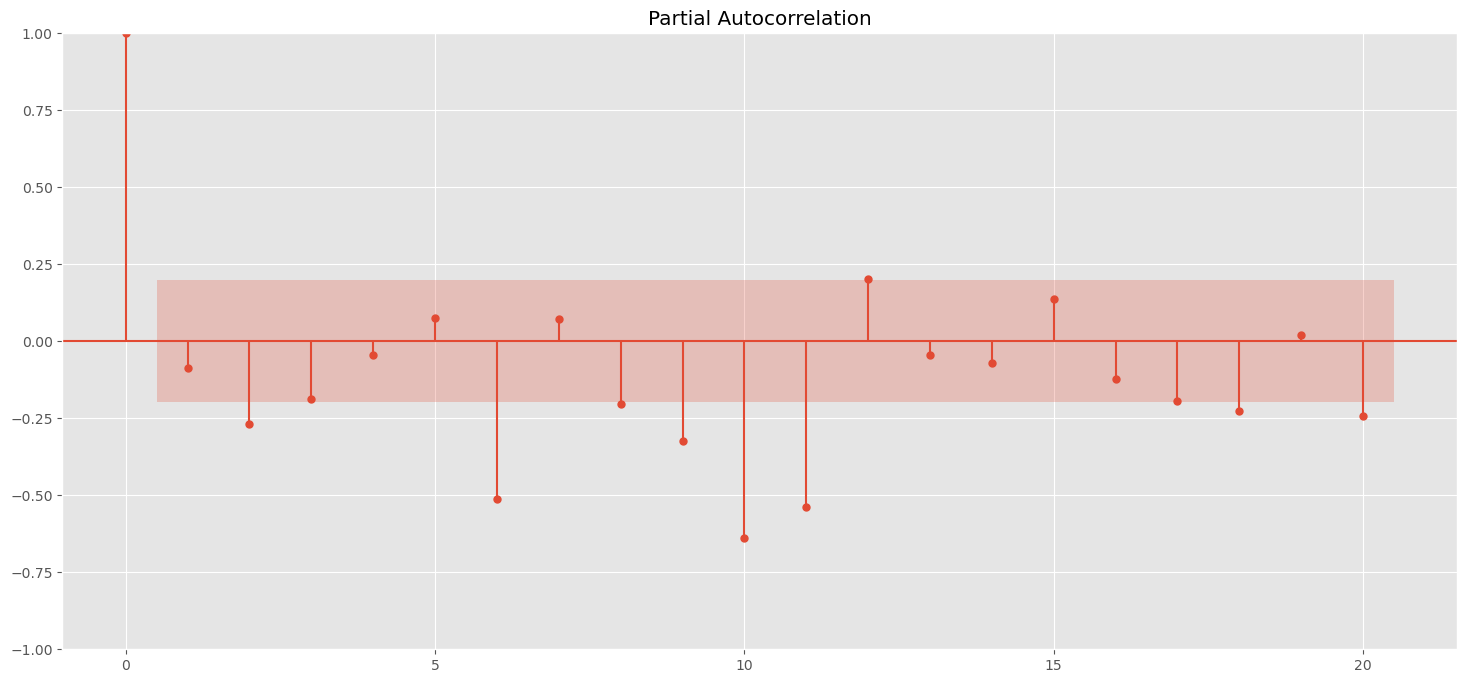

In [10]:
plot_pacf(all_yrs['Total Rev. First Difference'].dropna())
plt.show()

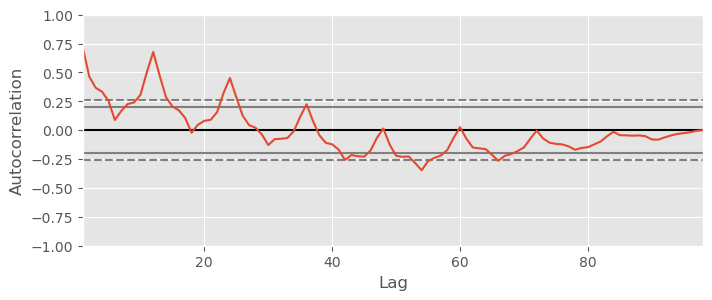

In [11]:
plt.figure(figsize=[8,3])
autocorrelation_plot(all_yrs['total_rev'])
plt.grid(True)
plt.show()

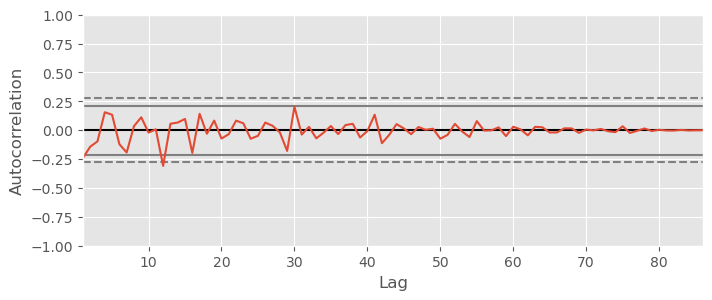

In [12]:
plt.figure(figsize=[8,3])
autocorrelation_plot(all_yrs['Total Rev. Seasonal Difference'].dropna())
plt.grid(True)
plt.show()

## Model Evaluation

In [13]:
# split into train and test sets
X = all_yrs['total_rev']
size = int(len(X) * 0.85)
train, test = X[:size], X[size:]

model = SARIMAX(train, order = (3,1,1), seasonal_order = (0,1,1,12))
model_fit_last = model.fit()

start = len(train)
end = len(train) + len(test)-1
predictions = model_fit_last.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA predictions')
predictions.index = test.index

evaluation_results = pd.DataFrame({'r2_score': r2_score(test, predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = np.round(mean_absolute_error(test, predictions), 3)
evaluation_results['mean_squared_error'] = np.round(mean_squared_error(test, predictions), 2)
evaluation_results['root_mean_squared_error'] = np.round(np.sqrt(mean_squared_error(test, predictions)), 3)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions-test)/np.abs(test))*100

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
predictions

period
2023-01-31    2.969076e+07
2023-02-28    2.507760e+07
2023-03-31    2.789105e+07
2023-04-30    3.041717e+07
2023-05-31    3.152848e+07
2023-06-30    3.122810e+07
2023-07-31    4.319040e+07
2023-08-31    4.747555e+07
2023-09-30    3.293014e+07
2023-10-31    3.119328e+07
2023-11-30    2.823431e+07
2023-12-31    3.373058e+07
2024-01-31    2.955530e+07
2024-02-29    2.495142e+07
2024-03-31    2.776612e+07
Name: SARIMA predictions, dtype: float64

In [15]:
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error
0,0.918209,1471256.894,3.308099e+12,1818817.908,4.36614


In [16]:
for i in range(len(predictions)):
    diff_denar = predictions[i]-test[i]
    diff_euro = diff_denar/61.5
    print('timestamp=%s, predicted=%.2f, expected=%.2f, difference=%.2f, difference_euro=%.2f' % (str(test.index[i])[:10], predictions[i], test[i], diff_denar, diff_euro))

timestamp=2023-01-31, predicted=29690763.06, expected=29889000.00, difference=-198236.94, difference_euro=-3223.36
timestamp=2023-02-28, predicted=25077596.79, expected=24661500.00, difference=416096.79, difference_euro=6765.80
timestamp=2023-03-31, predicted=27891054.80, expected=28597500.00, difference=-706445.20, difference_euro=-11486.91
timestamp=2023-04-30, predicted=30417170.16, expected=31795500.00, difference=-1378329.84, difference_euro=-22411.87
timestamp=2023-05-31, predicted=31528480.95, expected=31303500.00, difference=224980.95, difference_euro=3658.23
timestamp=2023-06-30, predicted=31228099.90, expected=32287500.00, difference=-1059400.10, difference_euro=-17226.02
timestamp=2023-07-31, predicted=43190397.03, expected=47047500.00, difference=-3857102.97, difference_euro=-62717.12
timestamp=2023-08-31, predicted=47475547.38, expected=48492750.00, difference=-1017202.62, difference_euro=-16539.88
timestamp=2023-09-30, predicted=32930137.14, expected=33486750.00, differen

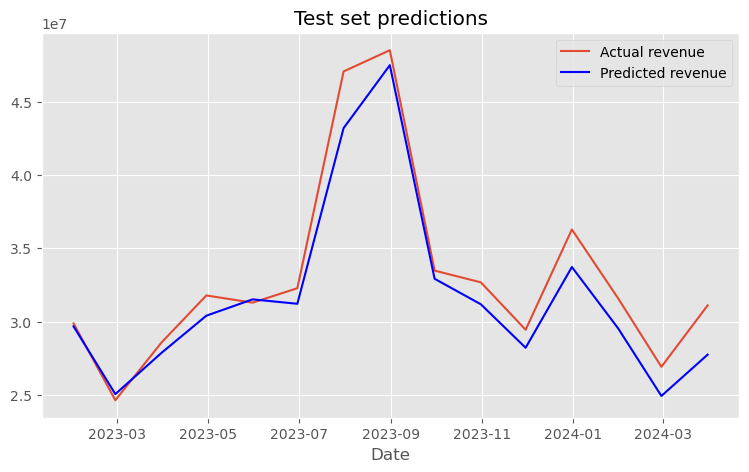

In [17]:
plt.figure(figsize=(9,5))
plt.plot(test, label='Actual revenue')
plt.plot(predictions, color='blue', label='Predicted revenue')
plt.title("Test set predictions")
plt.xlabel("Date")
plt.legend()
plt.show()

### Build SARIMA model

The correlogram on the bottom right shows that there is no autocorrelation in the residuals, and so they are effectivelely white noise. Therefore, these residuals are uncorrelated and the mean is close to zero.

In [18]:
all_yrs.tail()

,total_rev,Total Rev. First Difference,Total Rev. Seasonal Difference
period,,,
2023-11-30,29458500,-3228750.0,-645750.0
2023-12-31,36285000,6826500.0,1168500.0
2024-01-31,31598700,-4686300.0,-627300.0
2024-02-29,26937000,-4661700.0,565800.0
2024-03-31,31119000,4182000.0,246000.0


C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\base\optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(


                                     SARIMAX Results                                      
Dep. Variable:                          total_rev   No. Observations:                   98
Model:             SARIMAX(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1398.125
Date:                            Tue, 16 Apr 2024   AIC                           2808.251
Time:                                    10:31:00   BIC                           2822.906
Sample:                                         0   HQIC                          2814.146
                                             - 98                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0227     53.408      0.000      1.000    -104.654     104.700
ar.L2         -0.1066      3.704   

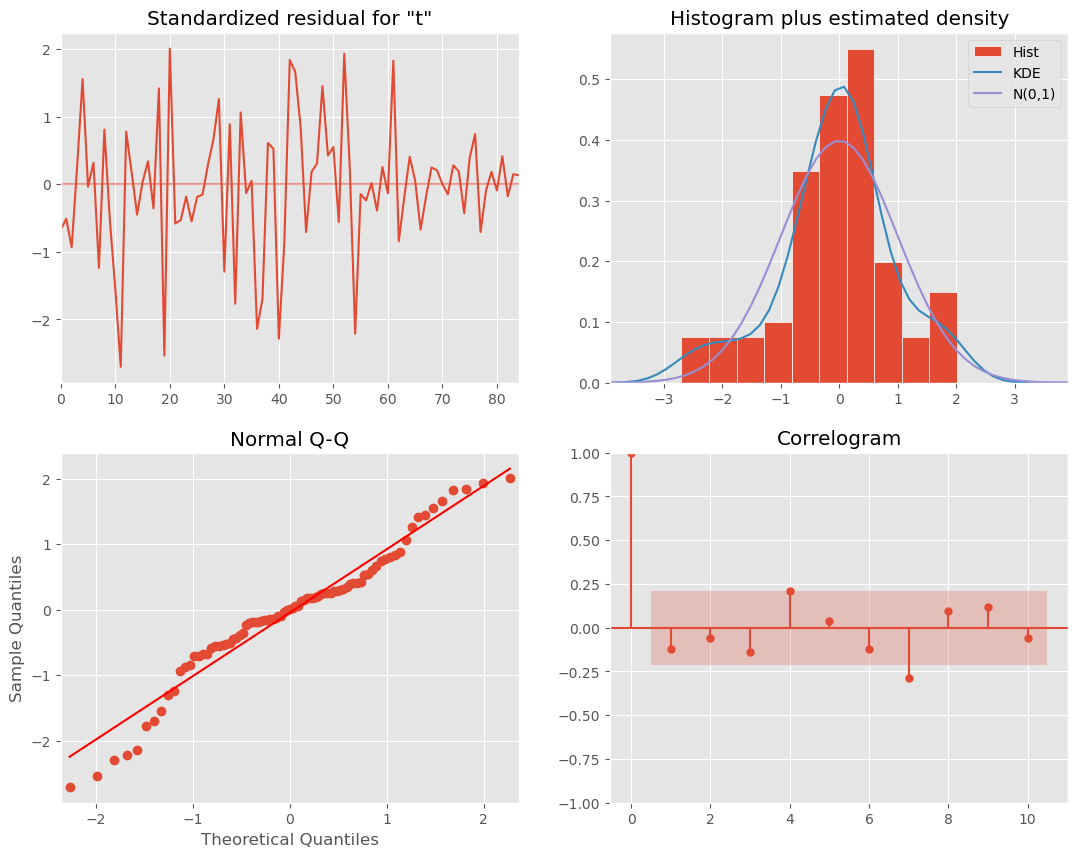

In [19]:
model = SARIMAX(all_yrs['total_rev'], order = (3,1,1), seasonal_order = (0,1,1,12))
model_fit = model.fit(dis=-1)

print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(13,10))
plt.show()

C:\Users\Kristina.popova\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


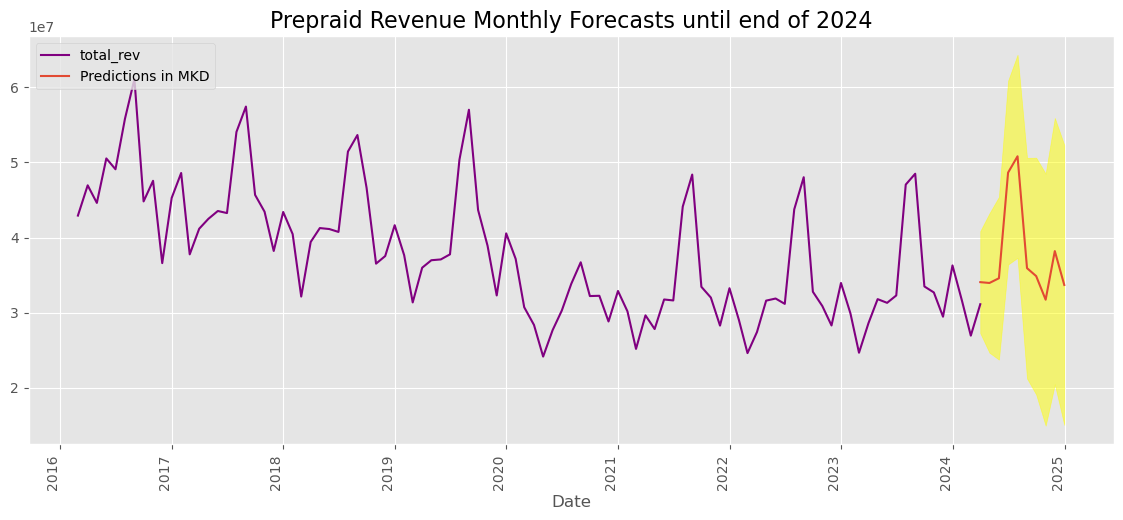

In [20]:
forecast_index = ['2024-03-31', '2024-04-30', '2024-05-31', 
                  '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30', 
                  '2024-10-31', '2024-11-30', '2024-12-31']

forecast_values = model_fit.get_forecast(steps=len(forecast_index))
forecast_values_mean = pd.DataFrame()
forecast_values_mean['Predictions in MKD'] = forecast_values.predicted_mean
forecast_values_mean['period'] = pd.to_datetime(forecast_index)
forecast_values_mean = forecast_values_mean.set_index('period')

forecast_ci = forecast_values.conf_int()
forecast_ci = forecast_ci.set_index(pd.to_datetime(forecast_index))

#all_yrs = all_yrs.reset_index()
ax = all_yrs.plot(y='total_rev', figsize=(14,6), legend=True, color='purple')

# Plot the forecasted values
forecast_values_mean.plot(ax=ax, label='forecast_rev', figsize=(14,6), grid=True)

# Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='yellow', alpha=.5)

plt.title("Prepraid Revenue Monthly Forecasts until end of 2024", size=16)
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
ax.axes.get_xaxis().set_visible(True)

plt.show()

In [21]:
forecast_values_mean.iloc[0]['Predictions in MKD']/61.5

553814.4862143042

In [22]:
today = date.today()
today = str(today)
#results = pd.DataFrame()
#results['Date'] = pd.period_range(start='2022-10', end='2024-12', freq='M')

forecasts = forecast_values_mean['Predictions in MKD'].values
results = pd.read_csv("prepaid_revenue_forecasts.csv")
lens = len(results)-len(forecasts)
results['Forecast as of ' + today + " (MKD)"] = np.append(lens * [0], forecasts)
results['Forecast as of ' + today + " (EUR)"] = np.round(results['Forecast as of ' + today + " (MKD)"] / 61.5, 2)
results.to_csv("prepaid_revenue_forecasts.csv", index=False)

In [23]:
results

,Date,Forecast as of 2022-10-06 (MKD),Forecast as of 2022-10-06 (EUR),Forecast as of 2022-11-03 (MKD),Forecast as of 2022-11-03 (EUR),Forecast as of 2022-12-02 (MKD),Forecast as of 2022-12-02 (EUR),Forecast as of 2023-01-16 (MKD),Forecast as of 2023-01-16 (EUR),Forecast as of 2023-01-20 (MKD),...,Forecast as of 2023-12-05 (MKD),Forecast as of 2023-12-05 (EUR),Forecast as of 2024-01-09 (MKD),Forecast as of 2024-01-09 (EUR),Forecast as of 2024-02-15 (MKD),Forecast as of 2024-02-15 (EUR),Forecast as of 2024-03-04 (MKD),Forecast as of 2024-03-04 (EUR),Forecast as of 2024-04-16 (MKD),Forecast as of 2024-04-16 (EUR)
0,2022-10,30644355.68,498282.21,0.00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
1,2022-11,26638588.80,433147.79,26860710.41,436759.52,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
2,2022-12,31934229.69,519255.77,32156395.33,522868.22,3.379718e+07,549547.59,0.000000e+00,0.00,0.000000e+00,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
3,2023-01,28310998.34,460341.44,28535431.50,463990.76,2.985155e+07,485391.05,2.927739e+07,476055.11,2.927739e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
4,2023-02,24148178.15,392653.30,24377432.21,396381.01,2.577044e+07,419031.59,2.338072e+07,380174.36,2.338072e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
5,2023-03,26602487.34,432560.77,26831359.06,436282.26,2.821090e+07,458713.87,2.608864e+07,424205.46,2.608864e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
6,2023-04,28825297.34,468704.02,29051961.18,472389.61,3.046319e+07,495336.38,2.977265e+07,484108.17,2.977265e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
7,2023-05,29790882.13,484404.59,30017718.85,488092.99,3.139244e+07,510446.25,3.024591e+07,491803.39,3.024591e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
8,2023-06,29658876.58,482258.16,29886270.56,485955.62,3.130173e+07,508971.29,2.972243e+07,483291.50,2.972243e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
9,2023-07,40506600.03,658643.90,40729425.12,662267.08,4.212323e+07,684930.59,4.336146e+07,705064.46,4.336146e+07,...,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00,0.000000e+00,0.00
